# Deep Learning with PyTorch : Build a Generative Adversarial Network 

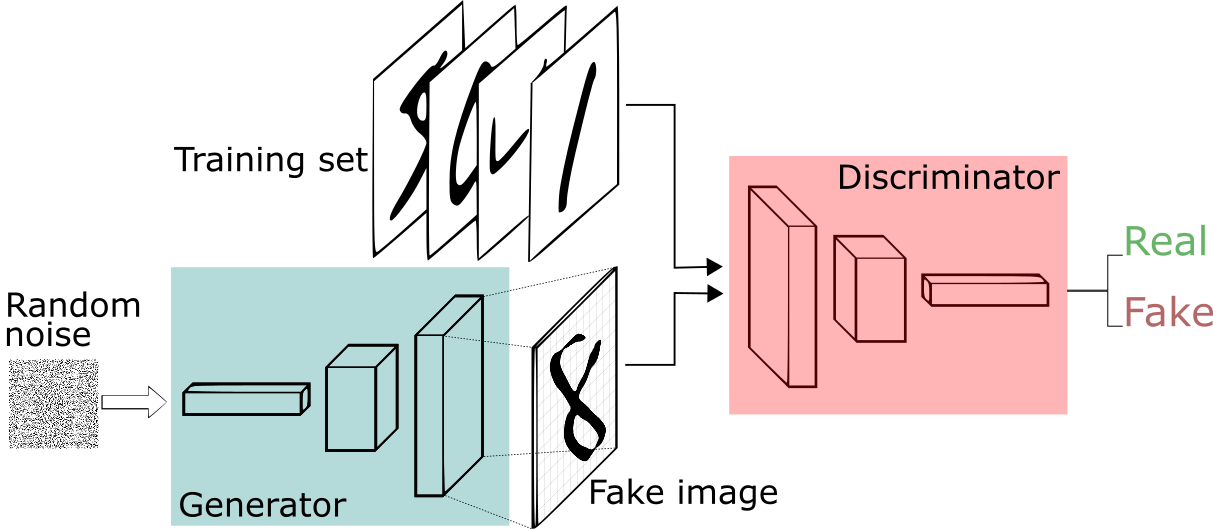

In [33]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
bs = 128
noise_dim = 64 # shape of random noise tensor for generator

In [36]:
# optimizer params
lr = 2e-3
beta1 = 0.5
beta2 = 0.99

# training params
epochs = 20

# Load MNIST Dataset 

In [37]:
from torchvision import datasets
from torchvision import transforms as T

In [38]:
train_augs = T.Compose([
                        T.RandomRotation([-20,20]),  # range for degree of rotation
                        T.ToTensor(),  # convert and normalize, shift channel to 0th axis
])

In [39]:
train_ds = datasets.MNIST('data/', download=True, train=True, transform=train_augs)  # train = True for gans

In [40]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


Train data has image and label

In [41]:
image, label = train_ds[0]

In [42]:
image.shape

torch.Size([1, 28, 28])

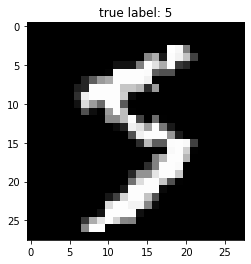

In [43]:
plt.title(label=f'true label: {label}')
ax = plt.imshow(image.squeeze(), cmap='gray')

In [44]:
len(train_ds)

60000

# Load Dataset Into Batches 

In [49]:
from torch.utils.data import dataloader
from torchvision.utils import make_grid # to plot multiple images

In [50]:
dataloader.DataLoader

torch.utils.data.dataloader.DataLoader

In [52]:
train_dl = dataloader.DataLoader(train_ds, batch_size=bs, shuffle=True)

In [54]:
len(train_dl)  # total no of batches

469

In [57]:
data_iter = iter(train_dl)

In [58]:
images, label = next(data_iter)

In [60]:
images.shape

torch.Size([128, 1, 28, 28])

In [67]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

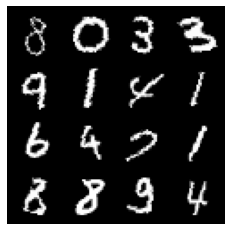

In [66]:
show_tensor_images(images)

# Create Discriminator Network 
Binary classifier that tells if image is real or not. 

In [68]:
#In case if torch summary is not installed 
# !pip install torchsummary

In [70]:
from torch import nn
from torchsummary import summary # summarize the model

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [72]:
def get_disc_block(i, o, k, s):
  block = nn.Sequential(
      nn.Conv2d(in_channels=i, out_channels=o, kernel_size=k, stride=s),
      nn.BatchNorm2d(o),
      nn.LeakyReLU(0.2),
  )
  return block

In [86]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block1 = get_disc_block(1, 16, 3, 2)
    self.block2 = get_disc_block(16, 32, 5, 2)
    self.block3 = get_disc_block(32, 64, 5, 2)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(64, 1)  

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.fc(self.flatten(x))
    # predicting direcly the class since we will use the BCE which takes raw acts
    # not applying sigmoid
    return x

In [87]:
D = Discriminator().to(device)

In [88]:
summary(D, input_size=(1,28,28))  # torchsummary not part of torch but independent

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 
Given random noise, generator network makes a realistic image

In [89]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [90]:
nn.ConvTranspose2d # for deconvolution

torch.nn.modules.conv.ConvTranspose2d

In [126]:
def get_gen_block(i, o, k, s, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=i, out_channels=o, kernel_size=k, stride=s),
        nn.Tanh(),
      )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels=i, out_channels=o, kernel_size=k, stride=s),
      nn.BatchNorm2d(o),
      nn.ReLU(),
    )

In [134]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.block1 = get_gen_block(noise_dim, 256, 3, 2)
    self.block2 = get_gen_block(256, 128, 4, 1)
    self.block3 = get_gen_block(128, 64, 3, 2)
    self.block4 = get_gen_block(64, 1, 4, 2, final_block=True)

  def forward(self, x):
    x = x.view(-1, self.noise_dim, 1,1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

In [135]:
noise_dim

64

In [136]:
G = Generator(noise_dim).to(device)

In [137]:
summary(G, input_size=(64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [133]:
# G(torch.rand(2,64).to(device))

In [139]:
# Replace Random initialized weights to Normal weights  
# for robust training

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

I thought by default the weights were kaiming-he

In [140]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer
Make real loss and fake loss

In [158]:
def real_loss(disc_pred, targs=None):
  criterion = nn.BCEWithLogitsLoss()
  targs = torch.ones_like(disc_pred)
  # since all images are real, target is 1
  return criterion(disc_pred, targs)

In [159]:
disc_pred = D(torch.rand(128,1,28,28).to(device))

In [160]:
real_loss(disc_pred)

tensor(0.6369, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [161]:
def fake_loss(disc_pred, targs=None):
  criterion = nn.BCEWithLogitsLoss()
  targs = torch.zeros_like(disc_pred)
  # since all images are fake, target is 0
  return criterion(disc_pred, targs)

In [162]:
fake_loss(disc_pred)

tensor(0.7527, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Optimizer for generator and discriminator

In [163]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
D_opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.99)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)

In [164]:
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
G_opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.99)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 1 | Dloss: 0.664388498644839 Gloss: 0.7576384987912452


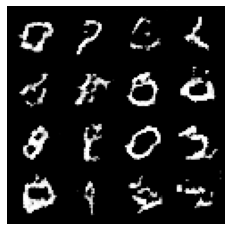

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 2 | Dloss: 0.6372477652421639 Gloss: 0.8401881945666982


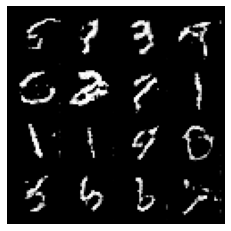

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 3 | Dloss: 0.6346913447766416 Gloss: 0.869877727301136


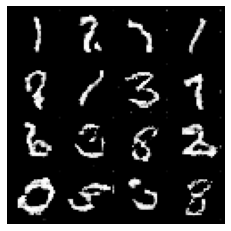

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 4 | Dloss: 0.6392321310826202 Gloss: 0.8656203534557367


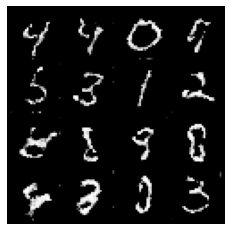

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 5 | Dloss: 0.6405758518399969 Gloss: 0.8625177170422031


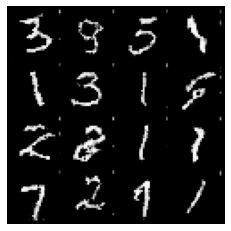

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 6 | Dloss: 0.6394377738428014 Gloss: 0.864438325611513


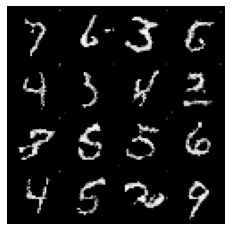

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 7 | Dloss: 0.6350876184414699 Gloss: 0.8779025081632488


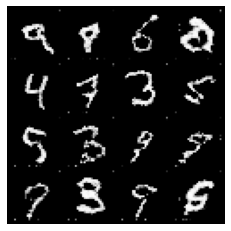

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 8 | Dloss: 0.6305963067866084 Gloss: 0.8957655631911272


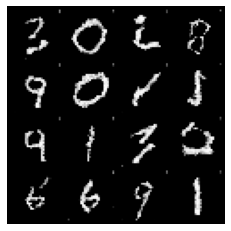

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 9 | Dloss: 0.6117866823413988 Gloss: 0.9376601975863931


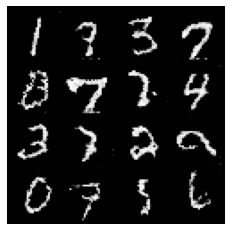

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 10 | Dloss: 0.6007674218240832 Gloss: 0.9812042757646361


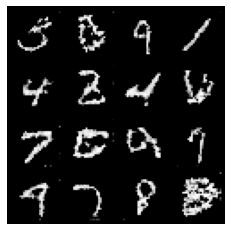

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 11 | Dloss: 0.5934004801422802 Gloss: 1.0072423959337573


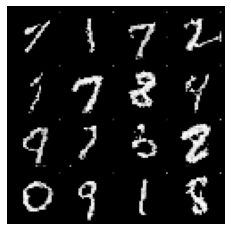

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 12 | Dloss: 0.5869191803657678 Gloss: 1.033630535165384


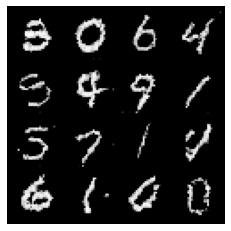

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 13 | Dloss: 0.5738652184573826 Gloss: 1.0691549497118382


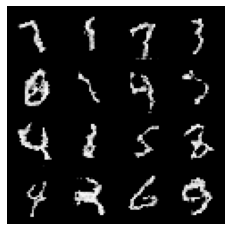

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 14 | Dloss: 0.5621366803961267 Gloss: 1.1193667497716224


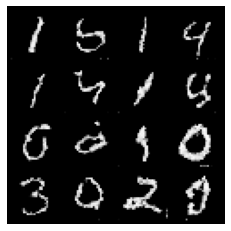

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 15 | Dloss: 0.5542563276250225 Gloss: 1.1458625778206375


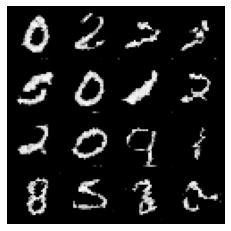

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 16 | Dloss: 0.5481995219614968 Gloss: 1.1695396293963451


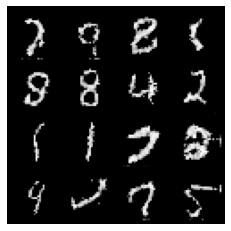

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 17 | Dloss: 0.5451110683397443 Gloss: 1.1881450541746388


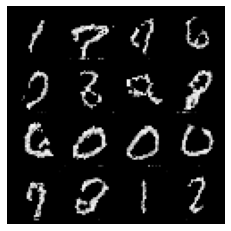

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 18 | Dloss: 0.538756325999811 Gloss: 1.2078465572806563


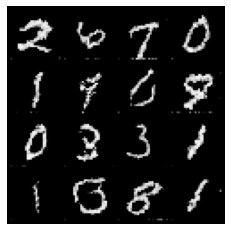

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 19 | Dloss: 0.5320703786954697 Gloss: 1.2377992325754308


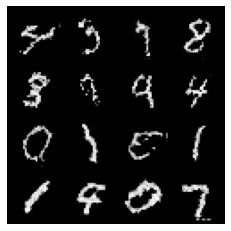

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 20 | Dloss: 0.5245219894817897 Gloss: 1.256968603205325


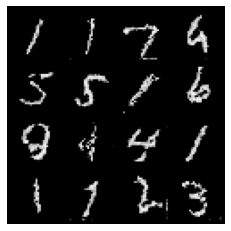

In [165]:
for i in range(epochs):
  tot_dloss = 0.0
  tot_gloss = 0.0
  for images, _ in tqdm(train_dl):
    images = images.to(device)

    # start with Discriminator
    D_opt.zero_grad()
    # get fake image
    noise = torch.randn(bs, noise_dim).to(device) # the noise for the generator
    fake_image = G(noise)  # pass noise to generator
    D_pred = D(fake_image) # pass generated image to discriminator to get binary outs
    # calc loss for fake image
    D_fake_loss = fake_loss(D_pred)  # loss for the fake image assuming the image is fake
    # preds for real image
    D_pred = D(images)
    D_real_loss = real_loss(D_pred)  # loss for the real image assuming it is real
    D_loss = (D_fake_loss + D_real_loss)*0.5
    tot_dloss += D_loss.item()
    D_loss.backward()
    D_opt.step()

    # repeat for Generator
    G_opt.zero_grad()
    # get fake image
    noise = torch.randn(bs, noise_dim).to(device) # the noise for the generator
    fake_image = G(noise)  # pass noise to generator
    D_pred = D(fake_image) # pass generated image to discriminator to get binary outs
    # because we want the generated image to be closs to real, use real loss
    G_loss = real_loss(D_pred)  # loss for the real image assuming it is real
    tot_gloss += G_loss.item()
    G_loss.backward()
    G_opt.step()
  
  avg_dloss = tot_dloss/len(train_dl)
  avg_gloss = tot_gloss/len(train_dl)
  tqdm.write(f'epoch {i+1} | Dloss: {avg_dloss} Gloss: {avg_gloss}')

  show_tensor_images(fake_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


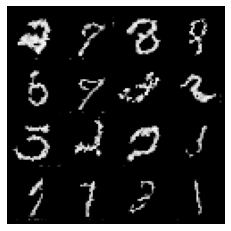

In [170]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(bs, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)